In [2]:
import netCDF4 as nc
import numpy as np
from matplotlib import pylab as plt
import gsw
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
import os
import numpy.ma as ma
import tools_for_croco as to

In [3]:
# Paramètres de la simulation
pathname='/home/brout/Documents/UBO/M2/deep_ocean_modelling/rez0.1_600days2/'  # Path where all the different files are located. To extract
                                                                            # ncfiles, change their name with the pattern 'property.nc'
path_save='/home/brout/Documents/UBO/M2/GFD/projet/'

Re=6.4E6
dt=300             # 5 minutes
NWRT=288           # every 24 hours
Nz=32              # Number of vertical levels
dl=0.1             # resolution in degrees
delta_t=dt*NWRT
print(delta_t/3600)
time_sample=5
lon_min,lon_max=-82,-74
lat_min,lat_max=23,34


24.0


In [4]:
def rho_to_zeta(grid):
    '''
    Linear interpolation of a rho grid on a zeta grid
    '''
    return(0.25*(grid[1:,1:]+grid[1:,:-1]+grid[:-1,1:]+grid[:-1,:-1]))

def u_to_zeta(grid):
    return(0.5*(grid[1:,:]+grid[:-1,:]))

def v_to_zeta(grid):
    return(0.5*(grid[:,1:]+grid[:,:-1]))

def rho_to_u(grid):
    return(0.5*(grid[:,1:]+grid[:,:-1]))

def rho_to_v(grid):
    return(0.5*(grid[1:,:]+grid[:-1,:]))

In [5]:
# Function to have ticks with mathematical coordinates, not computer ones
def tickstring_lon(x_ticks):
    tick=[]
    for i in range(len(x_ticks)):
        if x_ticks[i]<0 and x_ticks[i]%1==0:
            tick.append(str(abs(int(x_ticks[i])))+'°W')
        elif x_ticks[i]>0 and x_ticks[i]%1==0:
            tick.append(str(int(x_ticks[i]))+'°E')
        elif x_ticks[i]<0:
            tick.append(str(abs(x_ticks[i]))+'°W')
        elif x_ticks[i]>0:
            tick.append(str(abs(x_ticks[i]))+'°E')
        else:
            tick.append('0°')
    return(tick)

def tickstring_lat(y_ticks):
    tick=[]
    for i in range(len(y_ticks)):
        if y_ticks[i]<0 and y_ticks[i]%1==0:
            tick.append(str(abs(int(y_ticks[i])))+'°S')
        elif y_ticks[i]>0 and y_ticks[i]%1==0:
            tick.append(str(int(y_ticks[i]))+'°N')
        elif y_ticks[i]<0:
            tick.append(str(abs(y_ticks[i]))+'°S')
        elif y_ticks[i]>0:
            tick.append(str(abs(y_ticks[i]))+'°N')
        else:
            tick.append('0°')
    return(tick)

In [6]:
def U10(tau_x,tau_y):
    tau=np.sqrt(tau_x**2+tau_y**2)
    cos,sin=tau_x/tau,tau_y/tau
    U_10=np.sqrt(tau/(1.225e-3))
    u10,v10=U_10*cos,U_10*sin
    return(u10,v10)

In [7]:
# Importation des fichiers nc.

file=pathname+'croco_his.nc'
his=nc.Dataset(file,'r',datamodel='NETCDF_CLASSIC',disk_format='hdf5')
his.variables.keys()

odict_keys(['spherical', 'xl', 'el', 'xi_rho', 'xi_u', 'eta_rho', 'eta_v', 'Vtransform', 's_rho', 's_w', 'sc_r', 'sc_w', 'Cs_r', 'Cs_w', 'hc', 'h', 'f', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'angle', 'mask_rho', 'time_step', 'scrum_time', 'time', 'zeta', 'ubar', 'vbar', 'u', 'v', 'temp', 'salt', 'w', 'bostr', 'wstr', 'sustr', 'svstr', 'AKt', 'hbl', 'hbbl', 'shflux', 'swflux', 'swrad'])

In [10]:
time_index=254
lon_rho=his['lon_rho'][:]
lat_rho=his['lat_rho'][:]
w=his['w'][time_index] #on the rho_grid
eta=his['zeta'][time_index]
topo=his['h'][:]
taux_ug=his['sustr'][time_index]
tauy_vg=his['svstr'][time_index]
lon_u,lat_u=his['lon_u'][:],his['lat_u'][:]
lon_v,lat_v=his['lon_v'][:],his['lat_v'][:]

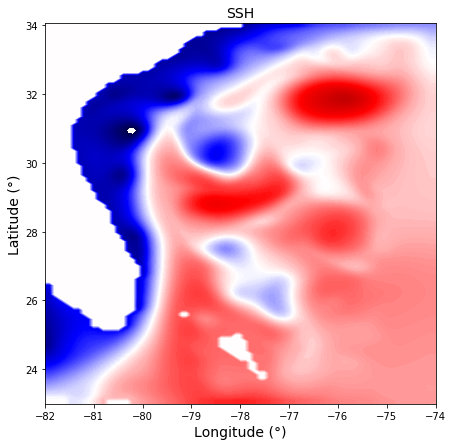

In [56]:
colormap='seismic'
eta_max=0.32
fig,ax=plt.subplots(figsize=(7,7))
ax.contourf(lon_rho,lat_rho,eta,cmap=colormap,levels=np.linspace(-eta_max,eta_max,200))
ax.set_xlabel('Longitude (°)',fontsize=14)
ax.set_ylabel('Latitude (°)',fontsize=14)
ax.set_title('SSH',fontsize=14)
plt.savefig(path_save+'SSH')

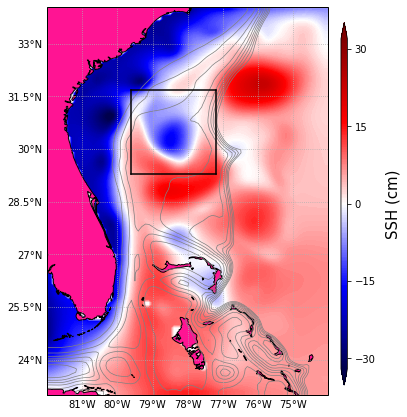

In [57]:
# Plot of the eddy kinetic energy over the last 12 months
# Plot of velocities with map
colormap='seismic'
proj=ccrs.PlateCarree()
#features
eta_max=32
land_10m=cfeature.NaturalEarthFeature(category='physical',
                            name='land',
                            scale='10m',
                            edgecolor='k',
                            facecolor='deeppink')

fig,ax=plt.subplots(figsize=(6,8))
plt.subplots_adjust(left = 0.1, right = 0.75, top = 1, bottom = 0.0)
ax=plt.axes(projection=proj)
gl1=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl1.xlabels_top = False
gl1.ylabels_right = False
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'size': 10, 'color': 'black'}
gl1.ylabel_style = {'size': 10, 'color': 'black'}


#adding features
ax.add_feature(land_10m)
#adding the velocity vector
mappable=ax.contourf(lon_rho,lat_rho,eta*100,cmap=colormap,levels=np.linspace(-eta_max,eta_max,200),extend='both')
ax.plot(lon_rho[latmin,lonmin:lonmax+1],lat_rho[latmin,lonmin:lonmax+1],c='k')
ax.plot(lon_rho[latmax,lonmin:lonmax+1],lat_rho[latmax,lonmin:lonmax+1],c='k')
ax.plot(lon_rho[latmin:latmax+1,lonmin],lat_rho[latmin:latmax+1,lonmin],c='k')
ax.plot(lon_rho[latmin:latmax+1,lonmax],lat_rho[latmin:latmax+1,lonmax],c='k')
ax.contour(lon_rho,lat_rho,topo,colors='grey',levels=np.linspace(0,2000,10),linewidths=.7)


#Colorbar
wi,hi  = 0.015,0.63                                            # Colorbar dimensions
xc,yc  = 0.78,0.18                                                # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable,cax,orientation='vertical')
cb.set_label(r'SSH (cm)',fontsize=15,labelpad=10)
cb.set_ticks(np.linspace(30,-30,5))
cb.ax.tick_params(labelsize=10)
plt.savefig(path_save+'SSH_global')

In [11]:
dx=(lon_v[:,1:]-lon_v[:,:-1])*np.pi/180*Re*np.cos(lat_v[:,:-1]*np.pi/180)
dy=(lat_u[1:,:]-lat_u[:-1,:])*Re*np.pi/180

In [15]:
depth=-100
hc = his.hc
Cs_r = his.Cs_r
Cs_w = his.Cs_w

topo=his.variables['h'][:] # on the rho grid
#f_zetagrid=0.25*(f[1:,1:]+f[:-1,:-1]+f[:-1,1:]+f[1:,:-1])



#Compute vertical coordinates 
(z_r0,z_w0) =  to.zlevs(topo,eta, hc, Cs_r, Cs_w)



#Interpolate a variable on a given depth
w100 = to.vinterp(w,z_r0,depth,topo=topo,cubic=1)
w700 = to.vinterp(w,z_r0,-700,topo=topo,cubic=1)
print(np.nanmin(w100))

-0.0007827342489195967


In [22]:
latmin,latmax=70,98
lonmin,lonmax=24,48
tau_x=0.5*(taux_ug[1:,:]+taux_ug[:-1,:])
tau_y=0.5*(tauy_vg[:,1:]+tauy_vg[:,:-1])
wscurl=(tauy_vg[:,1:]-tauy_vg[:,:-1])/dx-(taux_ug[1:,:]-taux_ug[:-1,:])/dy
tau_x_zoom=tau_x[latmin:latmax,lonmin:lonmax]
tau_y_zoom=tau_y[latmin:latmax,lonmin:lonmax]
u_zoom,v_zoom=U10(tau_x_zoom,tau_y_zoom)
U=np.sqrt(u_zoom**2+v_zoom**2)
print(wscurl.shape)

(126, 80)


In [23]:
lon_zoom=lon_rho[latmin:latmax,lonmin:lonmax]
lat_zoom=lat_rho[latmin:latmax,lonmin:lonmax]

w100_zoom=w100[latmin:latmax,lonmin:lonmax]
wmax=0.2
eta_zoom=eta[latmin:latmax,lonmin:lonmax]
wscurl_zoom=wscurl[latmin:latmax,lonmin:lonmax]

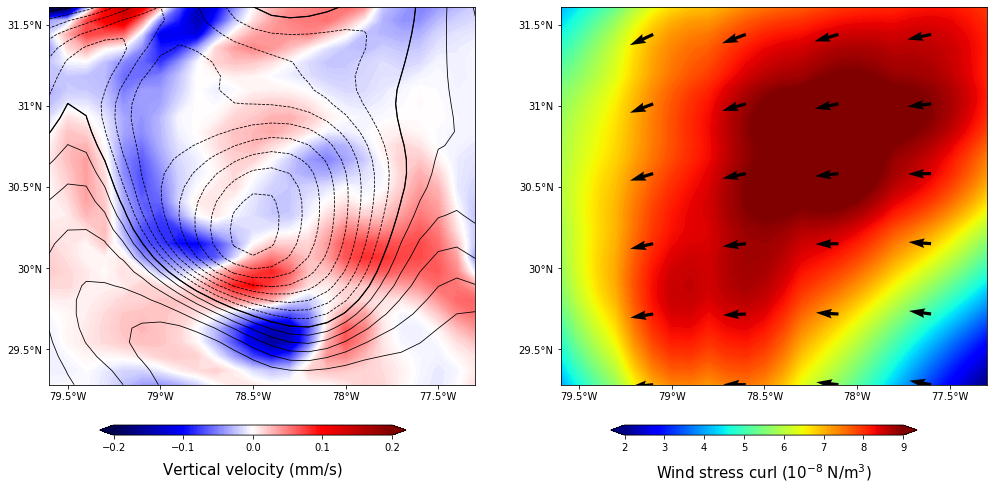

In [31]:
ticks_number_lon=5
ticks_number_lat=5
lon_min_zoom,lon_max_zoom=-79.5,-77.5
lat_min_zoom,lat_max_zoom=29.5,31.5
ss=5
colormap='seismic'

fig,(ax0,ax1)=plt.subplots(1,2,figsize=(14,7))
plt.subplots_adjust(left = 0.05, right =0.98, top = 0.95, bottom = 0.2)
mappable0=ax0.contourf(lon_zoom,lat_zoom,w100_zoom*1000,levels=np.linspace(-wmax,wmax,200),cmap=colormap,extend='both')
ax0.contour(lon_zoom,lat_zoom,eta_zoom*100,levels=np.linspace(-30,10,21),colors='k',linewidths=.8)
ax0.contour(lon_zoom,lat_zoom,eta_zoom,levels=0,colors='k',linewidths=1.2)
#ax0.set_xlabel('Longitude (°)',fontsize=14)
#ax0.set_ylabel('Latitude (°)',fontsize=14)
#ax0.set_title('100 m depth',fontsize=14)
# Set ticks for t = 10 days
x_ticks=np.linspace(lon_min_zoom,lon_max_zoom,ticks_number_lon)
x_strings=tickstring_lon(x_ticks)
plt.sca(ax0)
plt.xticks(x_ticks,x_strings)
y_ticks=np.linspace(lat_min_zoom,lat_max_zoom,ticks_number_lat)
y_strings=tickstring_lat(y_ticks)
plt.yticks(y_ticks,y_strings)

colormap='jet'

mappable1=ax1.contourf(lon_zoom,lat_zoom,wscurl_zoom*(10**8),levels=np.linspace(2,9,200),cmap=colormap,extend='both')
ax1.quiver(lon_zoom[::ss,::ss],lat_zoom[::ss,::ss],u_zoom[::ss,::ss],v_zoom[::ss,::ss])
#ax1.set_xlabel('Longitude (°)',fontsize=14)
#ax1.set_title('',fontsize=14)

# Set ticks for t = 10 days
plt.sca(ax1)
plt.xticks(x_ticks,x_strings)
plt.yticks(y_ticks,y_strings)
 

#Colorbar
wi,hi  = 0.304,0.02                                               # Colorbar dimensions
xc,yc  = 0.1,0.1                                                # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable0,cax,orientation='horizontal',extend='both')
cb.set_label(r'Vertical velocity (mm/s)',fontsize=15,labelpad=10)
cb.set_ticks(np.linspace(-wmax,wmax,5))

plt.sca(ax1)
wi,hi  = 0.304,0.02                                               # Colorbar dimensions
xc,yc  = 0.607,0.1                                                # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable1,cax,orientation='horizontal',extend='both')
cb.set_label(r'Wind stress curl ($10^{-8}$ N/m$^3$)',fontsize=15,labelpad=10)
cb.set_ticks(np.linspace(2,9,8))
plt.savefig(path_save+'w_horizontal')

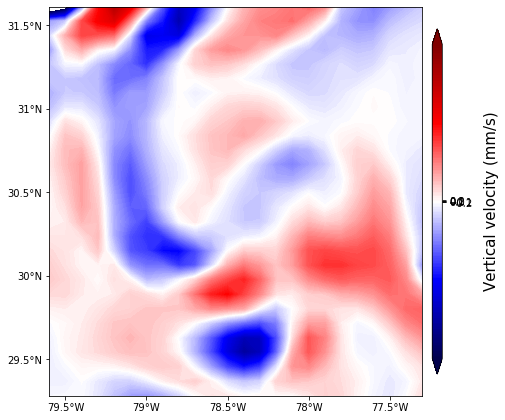

In [90]:
### Zoom
latmin,latmax=70,98
lonmin,lonmax=24,48
ticks_number_lon=5
ticks_number_lat=5
lon_min_zoom,lon_max_zoom=-79.5,-77.5
lat_min_zoom,lat_max_zoom=29.5,31.5
eta_zoom=eta[latmin:latmax,lonmin:lonmax]
lon_zoom=lon_rho[latmin:latmax,lonmin:lonmax]
lat_zoom=lat_rho[latmin:latmax,lonmin:lonmax]

w100_zoom=w100[latmin:latmax,lonmin:lonmax]
w700_zoom=w700[latmin:latmax,lonmin:lonmax]
wmax=0.2
colormap='seismic'
fig,ax0=plt.subplots(figsize=(7,6))
plt.subplots_adjust(left = 0.09, right =0.83, top = 0.95, bottom = 0.05)
ax0.contourf(lon_zoom,lat_zoom,w100_zoom*1000,levels=np.linspace(-wmax,wmax,200),cmap=colormap)
#ax0.set_xlabel('Longitude (°)',fontsize=14)
#ax0.set_ylabel('Latitude (°)',fontsize=14)

# Set ticks for t = 10 days
x_ticks=np.linspace(lon_min_zoom,lon_max_zoom,ticks_number_lon)
x_strings=tickstring_lon(x_ticks)
plt.sca(ax0)
plt.xticks(x_ticks,x_strings)
y_ticks=np.linspace(lat_min_zoom,lat_max_zoom,ticks_number_lat)
y_strings=tickstring_lat(y_ticks)
plt.yticks(y_ticks,y_strings)

#Colorbar
wi,hi  = 0.02,0.8                                               # Colorbar dimensions
xc,yc  = 0.85,0.1                                                # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable,cax,orientation='vertical',extend='both')
cb.set_label(r'Vertical velocity (mm/s)',fontsize=15,labelpad=10)
cb.set_ticks(np.linspace(-wmax,wmax,5))
plt.savefig(path_save+'w_hor_TC')


In [91]:
# to.zlevs is only for one particular level. this cell is to use it for more than one depth
def vinterp_multiple_depths(var3d,z,depths_array,topo=None,cubic=0):
    Nx,Ny=var3d.shape[2],var3d.shape[1]
    Nz=depths_array.shape[0]
    var_z=np.zeros((Nz,Ny,Nx))
    for i in range(Nz):
        var_z[i]=to.vinterp(var3d,z,depths_array[i],topo,cubic)
    return(var_z)

In [80]:
# w section
lat_sect=82
depth=-np.linspace(0,1000,100)
#Compute vertical coordinates 
(z_r0,z_w0) =  to.zlevs(topo,eta, hc, Cs_r, Cs_w)
wz=vinterp_multiple_depths(w,z_r0,depth,topo=topo,cubic=1)
wz_sect=wz[:,lat_sect,lonmin:lonmax]
print(np.nanmax(wz_sect))

0.0001083613610463094


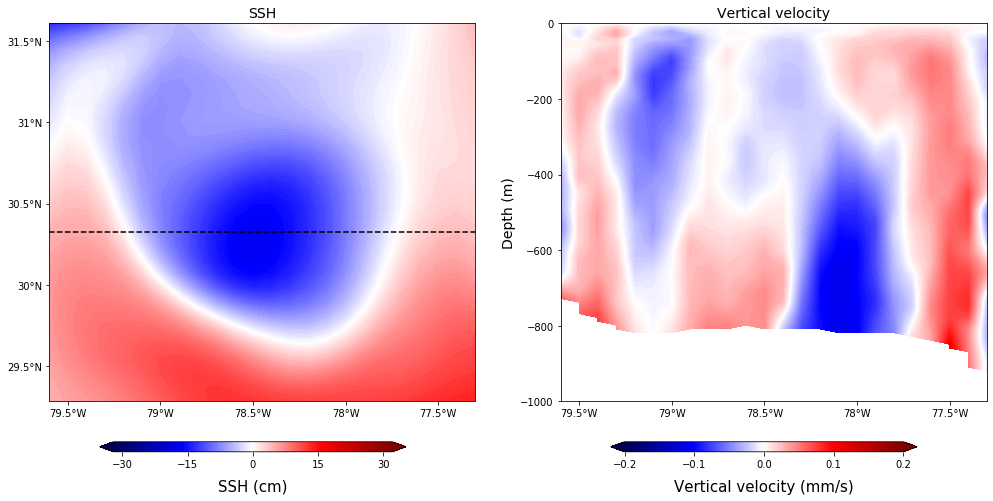

In [81]:
X,Y=np.meshgrid(lon_rho[lat_sect,lonmin:lonmax],depth)
colormap='seismic'
ticks_number_lon=5
ticks_number_lat=5
lon_min_zoom,lon_max_zoom=-79.5,-77.5
lat_min_zoom,lat_max_zoom=29.5,31.5

fig,(ax0,ax1)=plt.subplots(1,2,figsize=(14,7))
plt.subplots_adjust(left = 0.05, right =0.98, top = 0.95, bottom = 0.2)
mappable0=ax0.contourf(lon_zoom,lat_zoom,eta_zoom*100,cmap=colormap,levels=np.linspace(-eta_max,eta_max,200),extend='both')
ax0.set_title('SSH',fontsize=14)
plt.sca(ax0)
plt.hlines(lat_rho[lat_sect,0],lon_rho[lat_sect,lonmin],lon_rho[lat_sect,lonmax-1],linestyle='dashed')

# Set ticks for t = 10 days
x_ticks=np.linspace(lon_min_zoom,lon_max_zoom,ticks_number_lon)
x_strings=tickstring_lon(x_ticks)
plt.xticks(x_ticks,x_strings)
y_ticks=np.linspace(lat_min_zoom,lat_max_zoom,ticks_number_lat)
y_strings=tickstring_lat(y_ticks)
plt.yticks(y_ticks,y_strings)


mappable1=ax1.contourf(X,Y,wz_sect*1000,cmap=colormap,levels=np.linspace(-wmax,wmax,200),extend='both')
ax1.set_title('Vertical velocity',fontsize=14)
ax1.set_ylabel('Depth (m)',fontsize=14)
plt.sca(ax1)
plt.xticks(x_ticks,x_strings)

#Colorbar
wi,hi  = 0.304,0.02                                               # Colorbar dimensions
xc,yc  = 0.1,0.1                                                # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable0,cax,orientation='horizontal',extend='both')
cb.set_label(r'SSH (cm)',fontsize=15,labelpad=10)
cb.set_ticks(np.linspace(-30,30,5))

plt.sca(ax1)
wi,hi  = 0.304,0.02                                               # Colorbar dimensions
xc,yc  = 0.607,0.1                                                # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable1,cax,orientation='horizontal',extend='both')
cb.set_label(r'Vertical velocity (mm/s)',fontsize=15,labelpad=10)
cb.set_ticks(np.linspace(-wmax,wmax,5))
plt.savefig(path_save+'w_profile')